In [1]:
import os
import sys
import re
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact

import matplotlib as mpl
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
from larval_gonad.notebook import Nb
from larval_gonad.config import config

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../scrnaseq-wf/data/scrnaseq_combine_force')

last updated: 2018-08-29 
Git hash: b99606c0f732385e29bf233ca406fa3affd1370b


In [110]:
germ_cells = nbconfig.cluster_order[:4]
tpm = pd.read_parquet('../scrnaseq-wf/data/tpm.parquet')
expressed = tpm.index[(tpm.loc[:, germ_cells].sum(axis=1) > 0)].tolist()

In [169]:
def run_test(up, down, dat):
    a = dat.loc[["chr2L", "chr2R", "chr3L", "chr3R"]].sum()
    ab = a[f'{down} bias']
    an = a.sum() - ab

    x = dat.loc["chrX"]
    xb = x[f'{down} bias']
    xn = x.sum() - xb

    t, p = fisher_exact(np.array([[xb, xn], [ab, an]]), 'less')
    return p

In [174]:
def _plot(up, down, ax):
    df = pd.read_csv(f'../scrnaseq-wf/data/{up}_vs_{down}.tsv', sep='\t', index_col=0).query('p_val_adj <= 0.01')
    df.index.name = 'FBgn'

    genes_up = df.query('avg_logFC > 0').index.tolist()
    genes_down = df.query('avg_logFC < 0').index.tolist()

    chroms = nbconfig.fbgn2chrom.copy().query('chrom == ["chrX", "chr2L", "chr2R", "chr3L", "chr3R"]')
    chroms = chroms.reindex(expressed)
    
    chroms['sig'] = 'non-bias'
    chroms.loc[chroms.index.isin(genes_up), 'sig'] = f'{up} bias'
    chroms.loc[chroms.index.isin(genes_down), 'sig'] = f'{down} bias'

    dat = chroms.groupby('chrom').sig.value_counts()
    dat.columns = ['count']
    dat = dat.unstack().fillna(0)
    
    _dat = dat.div(dat.sum(axis=1), axis=0).loc[nbconfig.chrom_order[:5], [f'{down} bias', 'non-bias', f'{up} bias']]
    _dat.plot.bar(stacked=True, ax=ax, color=['b', 'grey', 'r'], width=.9)
    ax.set_title(f'{up} vs {down}')
    ax.legend_.set_visible(False)
    plt.setp(ax.get_xticklabels(), rotation=0)
    
    p = run_test(up, down, dat)
    if p <= 0.01:
        y = _dat.loc['chrX', f'{down} bias']
        ax.text(0, y, '*', color='white', va='bottom', ha='center')

Text(0,0.5,'Proportion of Genes Differentially Expressed')

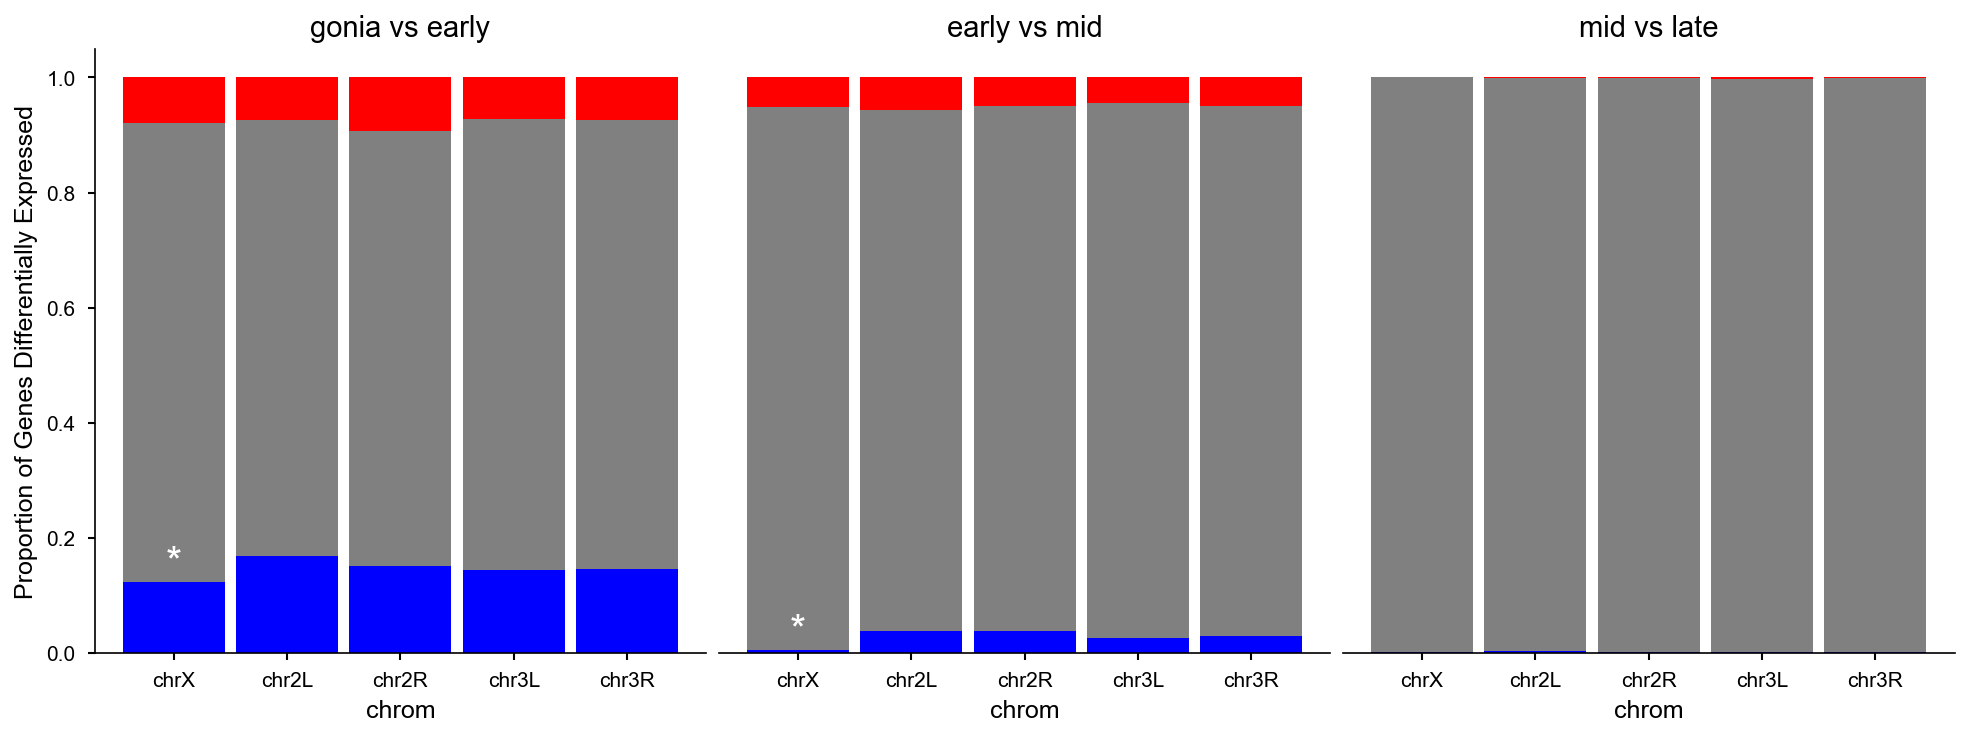

In [175]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plt.figaspect(1/3), sharex=True, sharey=True, gridspec_kw=dict(wspace=0.02))
_plot('gonia', 'early', ax1)
_plot('early', 'mid', ax2)
_plot('mid', 'late', ax3)

sns.despine(ax=ax1)
sns.despine(ax=ax2, left=True)
sns.despine(ax=ax3, left=True)

ax2.yaxis.set_visible(False)
ax3.yaxis.set_visible(False)

ax1.set_ylabel('Proportion of Genes Differentially Expressed')